In [1]:
#rebuild tensorflow with comiler flags
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import necessary libraries and packages
import pandas as pd
from pandas import DataFrame
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import warnings
from math import exp
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.python.keras.metrics import Metric

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
# Preferred settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [2]:
#Import Footprint and Biocapacity data
data = pd.read_csv('../Data/footprint-nfba-2019/data/nfa_2019_public_data.csv')
df = data

#Observe data shape and head
print(df.shape)
df.head(10)

(72186, 12)


,country,year,country_code,record,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon,total,qscore
0,Armenia,1992,1,AreaPerCap,1.402924e-01,0.199546,0.097188051,0.036888,0.029320,0.000000e+00,5.032351e-01,3A
1,Armenia,1992,1,AreaTotHA,4.830000e+05,687000.000000,334600,127000.000000,100943.000800,0.000000e+00,1.732543e+06,3A
2,Armenia,1992,1,BiocapPerCap,1.598044e-01,0.135261,0.084003213,0.013742,0.033398,0.000000e+00,4.262086e-01,3A
3,Armenia,1992,1,BiocapTotGHA,5.501762e+05,465677.972200,289207.1078,47311.551720,114982.279300,0.000000e+00,1.467355e+06,3A
4,Armenia,1992,1,EFConsPerCap,3.875102e-01,0.189462,1.26E-06,0.004165,0.033398,1.114093e+00,1.728629e+00,3A
5,Armenia,1992,1,EFConsTotGHA,1.334124e+06,652282.314700,4.328086713,14338.728980,114982.279300,3.835610e+06,5.951342e+06,3A
6,Armenia,1992,1,EFProdPerCap,1.598044e-01,0.135261,0,0.001266,0.033398,1.074631e+00,1.404360e+00,3A
7,Armenia,1992,1,EFProdTotGHA,5.501762e+05,465677.972200,0,4358.142036,114982.279300,3.699750e+06,4.834944e+06,3A
8,Armenia,1993,1,AreaPerCap,1.465909e-01,0.204573,0.099432069,0.037763,0.029320,0.000000e+00,5.176788e-01,3A
9,Armenia,1993,1,AreaTotHA,4.930000e+05,688000.000000,334400,127000.000000,98605.697630,0.000000e+00,1.741006e+06,3A


# Data Cleaning and Preprocessing


In [3]:
#check random data chunk
data.sample(5)

,country,year,country_code,record,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon,total,qscore
5219,Bermuda,1974,17,BiocapTotGHA,NaN,NaN,NaN,NaN,NaN,NaN,8374.184431,2B
50272,Guinea-Bissau,1978,175,EFProdPerCap,0.30168,0.355252,0.765187145,0.009434,0.032636,0.046139,1.510328,3A
62100,Tonga,2001,219,BiocapPerCap,NaN,NaN,NaN,NaN,NaN,NaN,1.232038,2B
40978,Mauritius,2001,137,BiocapPerCap,NaN,NaN,NaN,NaN,NaN,NaN,0.827285,2B
5495,Bermuda,2008,17,EFProdTotGHA,NaN,NaN,NaN,NaN,NaN,NaN,240030.634300,2B


We check the data-type of each column is of preferred data type

In [201]:
data.dtypes

total    float64
dtype: object

The Data type of the "country", "record", and "QScore" columns are of object type, which should be converted to String to be accessed or modified

In [5]:
#modify the datatype of country, record and QScore columns
data["country"] = data['country'].astype('string')
data["record"] = data['record'].astype('string')
data["qscore"] = data['qscore'].astype('string')

data.dtypes

country            string
year                int64
country_code        int64
record             string
crop_land         float64
grazing_land      float64
forest_land        object
fishing_ground    float64
built_up_land     float64
carbon            float64
total             float64
qscore             string
dtype: object

In order to carry out accurate pre-processing we have to first find out the number of Null Values in each column.

In [6]:
#check null values
print(data.isna().sum())
print(data.shape)

country               0
year                  0
country_code          0
record                0
crop_land         20472
grazing_land      20472
forest_land       20472
fishing_ground    20473
built_up_land     20473
carbon            20473
total                 9
qscore                1
dtype: int64
(72186, 12)


Since Entire rows contain NULL values, we have removed all such rows to clean our data. Rows were removed by removing rows that had less than 7 non-NULL cells.

In [7]:
#drop null values
df = data.dropna(axis=0, thresh=7)
#compression_opts = dict(method='zip', archive_name='out.csv')  
#df.to_csv('out.zip', index=False, compression=compression_opts) 

print(df.shape)
print(df.isna().sum())

(51714, 12)
country           0
year              0
country_code      0
record            0
crop_land         0
grazing_land      0
forest_land       0
fishing_ground    1
built_up_land     1
carbon            1
total             1
qscore            1
dtype: int64


The "qscore" is indicative of the reliability of Data. 
By dropping duplicate countries, we can realised for how reliable our overall data is for each country.

## Ecological Footprint

In [8]:
#Only include India's Ecological Footprint data 
df_India = df.loc[(df['country'] == "India") & (df['record'] == "EFConsPerCap") ,['year','total']]
df_India = df_India[['year', 'total']]
df_India.head(10)

,year,total
28060,1961,0.625609
28068,1962,0.629613
28076,1963,0.627844
28084,1964,0.622689
28092,1965,0.613171
28100,1966,0.619166
28108,1967,0.643092
28116,1968,0.652200
28124,1969,0.653963
28132,1970,0.674143


In [9]:
#Convert year to index
df_India.set_index('year', inplace=True)

#Convert year to DateTime object
df_India.index = pd.to_datetime(df_India.index, format='%Y')

In [10]:
#observe updated df
#df_India.head()
df_India.sample(5)

,total
year,
1992-01-01,0.809631
1967-01-01,0.643092
1977-01-01,0.680749
1999-01-01,0.881595
2000-01-01,0.857981


In [11]:
df_India.head()

,total
year,
1961-01-01,0.625609
1962-01-01,0.629613
1963-01-01,0.627844
1964-01-01,0.622689
1965-01-01,0.613171


# Exploratory Data Analysis

**Reviewing plots of the density of observations can provide further insight into the structure of the data**

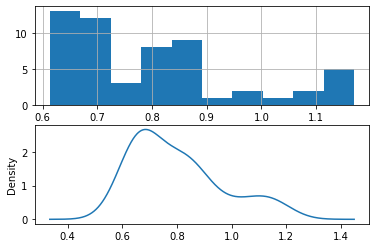

In [12]:
#observe density
pyplot.figure(1)
pyplot.subplot(211)
df_India.total.hist()
pyplot.subplot(212)
df_India.total.plot(kind='kde')
pyplot.show()

From the above graphs we can observe, 
- The distribution is not perfectly Gausian (normal distribution)
- The distribution in left shifted 
- Transformations might be useful prior to modelling

**Reviewing Box plot of emissions over decades provides insight into the trend and seasonality of the data**

<AxesSubplot:xlabel='year', ylabel='total'>

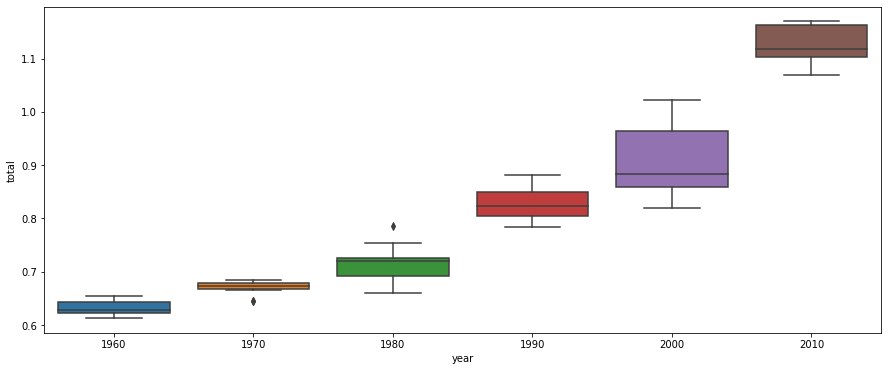

In [13]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df_India.total.index.year // 10 * 10, df_India.total, ax=ax)

From the above plot we can observe,
- Median values across decade confirms an irregular upward trend
- Exponential Increase in emissions

**Distribution and Normality Test**

Kurtosis of normal distribution -0.20987429144697334
Skewness of normal distribution 0.9051683015699763


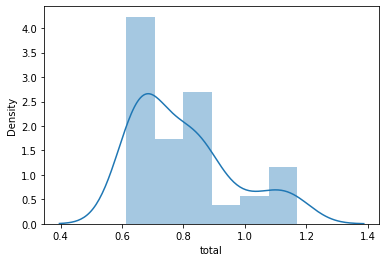

In [14]:
#observe distribution and normality
sns.distplot(df_India.total);
stats.normaltest(df_India.total)
print('Kurtosis of normal distribution {}'.format(stats.kurtosis(df_India.total)))
print( 'Skewness of normal distribution {}'.format(stats.skew(df_India.total)))

> - Kurtosis describes heaviness of the tails of distribution
    - Normal Distribution has a kurtosis of 0 (mesokurtic). A Positive value  shows us that the data has heavy-tails. A neagtive value (as observed) mean that data has ligh tails


> - Skewness 
    - if < -1 / > 1 -distribution is highly skewed. 
    - if -1 < skew < - 0.5 / 0.5 < skew < 1 - distribution is moderately skewed. (as observed)
    - if -0.5 < skew < 0.5 - distribution is approximately similar

,count,mean,std,min,25%,50%,75%,max
total,56.0,0.799507,0.16176,0.613171,0.67307,0.768282,0.86481,1.169753


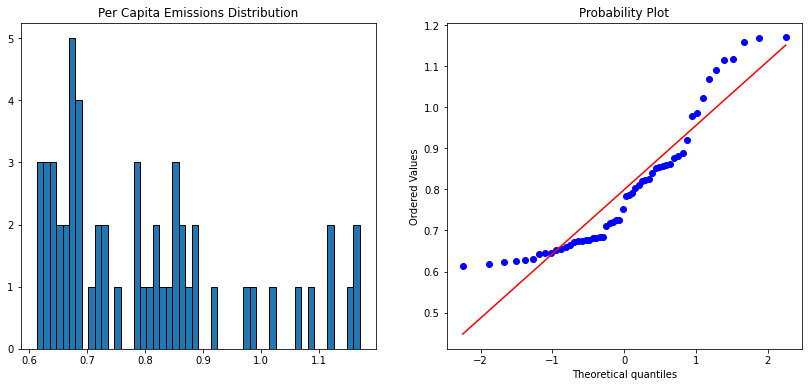

In [15]:
#observe distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df_India.total.hist(bins=50,edgecolor='black', grid=False)
plt.title('Per Capita Emissions Distribution')

plt.subplot(1,2,2)
stats.probplot(df_India.total, plot=plt);
#print("Skewness: %f" % df['Consumption'].skew())
#print("Kurtosis: %f" % df['Consumption'].kurt())
df_India.describe().transpose()

Normal probability plot shows that data set has irregular distribution, with trends

**Before starting to analyse the stationarity of data, lets need to understand the trend, seasonality and bias of our data by Decomposing** 

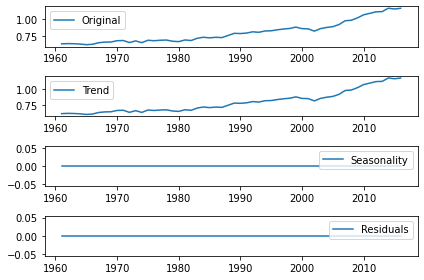

In [16]:
#observe trend and seasonality
from pylab import rcParams
decomposition = sm.tsa.seasonal_decompose(df_India.total, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_India.total, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

With Observations from decomposing we observe,
- No seasonal characteristics of Data
- Constant residual
- Exponential Increaseing trend

### Exponential Smoothing

#### Naive Model Using Holt-Winter's Method

We start with Holt's method, which does not account for seasonality

In [165]:
# Train-test split
df_es = df_India
x = df_es.index
y = df_es['total']

estrain = df_es.loc[:'2011-01-01']
estest = df_es.loc['2011-01-01':]

In [203]:
df_es.shape

(56, 1)

**Holt's Method - Double Exponential Smoothening**

using trend as additive

In [167]:
#apply double exponential smoothening
model_des = ExponentialSmoothing(estrain.total,trend = 'add')
model_des_fit = model_des.fit()
estrain['DES_model'] = model_des_fit.fittedvalues.shift(-1)

<AxesSubplot:xlabel='year'>

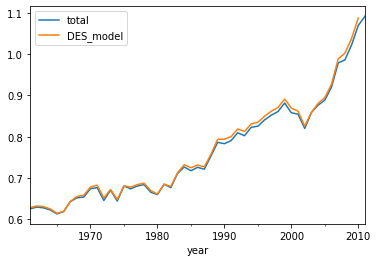

In [168]:
# observe the DES model against the original data
estrain[['total','DES_model']].plot(legend = True)

Lets observe a closer look to analyse the results better

<AxesSubplot:xlabel='year'>

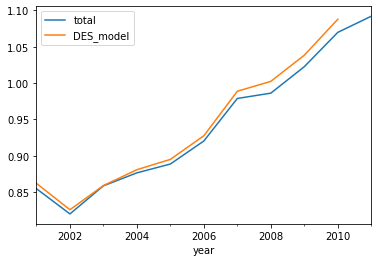

In [169]:
#observe a closer look
estrain[['total','DES_model']]['2001-01-01':'2016-01-01'].plot(legend = True)

From above, we observe Double Exponential Smoothening results looks reasonable well

**Holt-Winter's Method - Triple Exponential Smoothening**

Using trend and seasonality as multiplicative. Setting the number of seasonal_periods as 12 (yearly)

In [170]:
model_tes = ExponentialSmoothing(estrain.total,trend = 'add', seasonal = 'add', seasonal_periods=12)
model_tes_fit = model_tes.fit()
estrain['TES_model'] = model_tes_fit.fittedvalues.shift(-1)

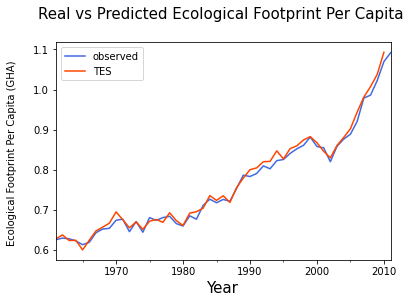

In [172]:
# observe the DES model against the original data
ax = estrain.total.plot(label='observed', color='royalblue', legend=True)
estrain.TES_model.plot(ax=ax, label='TES', color='orangered', legend=True )

ax.set_xlabel('Year', size=15)
ax.set_ylabel('Ecological Footprint Per Capita (GHA) \n', size=10)
ax.set_title('Real vs Predicted Ecological Footprint Per Capita \n', size=15)

plt.legend()
plt.show()

Lets observe Results of Double and Triple Exponential Smoothening

<AxesSubplot:xlabel='year'>

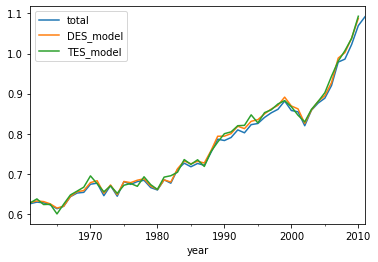

In [173]:
# observe the DES model against the original data
estrain[['total','DES_model','TES_model']].plot(legend = True)

Lets observe a closer look to analyse the results better

<AxesSubplot:xlabel='year'>

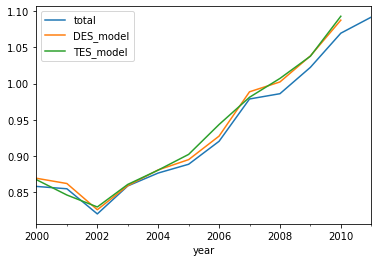

In [174]:
#observe a closer look
estrain[['total','DES_model', 'TES_model']]['2000-01-01':'2016-01-01'].plot(legend = True)

From above, we observe both Double Exponential Smoothening, Triple Exponential Smoothening results looks similar and  reasonably well

**Double and Triple Exponential Models : Forecasts**

Lets forecast on test set of data

In [175]:
#forecast on test set
test_des = model_des_fit.forecast(6)
test_tes = model_tes_fit.forecast(6)

<AxesSubplot:xlabel='year'>

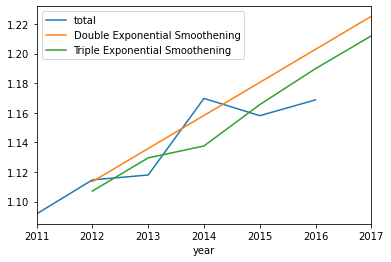

In [176]:
# Plotting Test predictions against the test set
estest['total'].plot(legend = True)
test_des.plot(legend = True, label = "Double Exponential Smoothening")
test_tes.plot(legend = True, label = "Triple Exponential Smoothening")

We Evaluate the forecast using RMSE as KPI

#### Evaluate Model

In [177]:
#evaluate mse
des_mse = mean_squared_error(estest.total, test_des)
tes_mse = mean_squared_error(estest.total, test_tes)

print(" RMSE for the Double Exponential Smoothening Model : ", round(np.sqrt(des_mse),3))
print(" RMSE for the Triple Exponential Smoothening Model : ", round(np.sqrt(tes_mse),3))

 RMSE for the Double Exponential Smoothening Model :  0.036
 RMSE for the Triple Exponential Smoothening Model :  0.025


In [250]:
from sklearn.metrics import mean_absolute_error
#Create a function to calculate AIC for our models
def MAE(test):
    return mean_absolute_error(estest.total, test)

print(" MAE for the Double Exponential Smoothening Model : ", round(MAE(test_des),3))
print(" MAE for the Triple Exponential Smoothening Model : ", round(MAE(test_tes),3))

 MAE for the Double Exponential Smoothening Model :  0.033
 MAE for the Triple Exponential Smoothening Model :  0.022


In [179]:
#write a function to calculate MAPE value
def MAPE(test): 
    return np.mean(np.abs((estest.total - test) / estest.total)) * 100

print(" MAPE for the Double Exponential Smoothening Model : ", round(MAPE(test_des),3))
print(" MAPE for the Triple Exponential Smoothening Model : ", round(MAPE(test_tes),3))

 MAPE for the Double Exponential Smoothening Model :  1.511
 MAPE for the Triple Exponential Smoothening Model :  1.383


From above results, we can observe 

>- RMSE of Holt-Winter's (TES) is **lesser** than DES 
>- MAE of Holt-Winter's (TES) is **lesser** than DES 
>- MAPE of Holt-Winter's (TES) is **lesser** than DES, means marginally better accuracy


***TES performs well for predicting data post 2011, so it will be used for forecasting***


#### Future Forecasts

In [29]:
test_tes_20 = model_tes_fit.forecast(20)
test_tes_20[6:20]

2018-01-01    1.241484
2019-01-01    1.279387
2020-01-01    1.293973
2021-01-01    1.322232
2022-01-01    1.344112
2023-01-01    1.371921
2024-01-01    1.387190
2025-01-01    1.409615
2026-01-01    1.417650
2027-01-01    1.445610
2028-01-01    1.469930
2029-01-01    1.492064
2030-01-01    1.521530
2031-01-01    1.559433
Freq: AS-JAN, dtype: float64

<AxesSubplot:xlabel='year'>

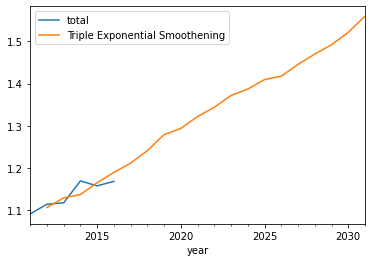

In [30]:
# Plotting Test predictions against the test set
test['total'].plot(legend = True)
test_tes_20.plot(legend = True, label = "Triple Exponential Smoothening")

We've achieved a exponentially smoothened forecast, lets compare this with ARIMA models.

Naive Holt's and Holt-Winter's exponential smoothening works with non-stationary data, But for ARIMA models we need to check stationarity to know the order of differnecing required inorder to obtain better results

Lets check stationarity and process the data

### Check for Stationarity
- Any time series data is said to be stationary if its statistical properties such as mean, variance remains constant over time

lets observe the properties 

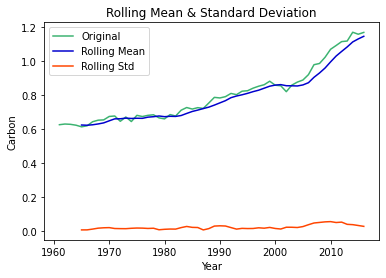

In [31]:
#Visualize India's CO2 emissions since 1900,
#including 5-year rolling mean and rolling standard deviation

roll_mean = df_India.rolling(window=5, center=False).mean()
roll_std = df_India.rolling(window=5, center=False).std()

plt.plot(df_India, color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Carbon')
plt.show(block=False)

Working with time series data we need to understand the nature of data, that is the trends and stationarity.

Stationarity can be checked by 
- performing an **Augmented Dickey-Fuller (ADF) test** 
- **ACF and PACF Plots**
- Plotting Rolling Statistics


#### Dickey-Fuller Test

In [32]:
#perform Dickey-Fuller test
test_result = adfuller(df_India.total[1:-1])
df_result = pd.Series(test_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_result

ADF Statistic                                                        2.498912
p-value                                                              0.999049
#Lags Used                                                                  1
No. of Observations Used                                                   52
Critical Values             {'1%': -3.562878534649522, '5%': -2.9189732840...
dtype: object

With p-value of 0.99 ( >0.05), we cannot reject that null hypothesis that this is non-stationary.

we also can see that our ADF statistic value (3.98) is greater than tha value -3.58 at 1%. This suggests that we cannot reject the null hypothesis with a significance of less than 1%, i.e. a low probability that the result is a statistical fluke. The process has unit root and in turn the timer series is un-stationary or does have time-dependent structure

As we observe the data is non-stationary, this cannot be fit for autocorrelation analysis as ACF and PACF assumes data stationary. Lets remedy this below before fitting our model.

## Addressing Trends and Stationarity

lets observe stationarity plotting rolling statistics and address the stationarity

### Log Transformation

In log transformation we apply logarithmic function to a point, and model the time series with the new log-transformed data. 

we can address lack of variance and covariance by log transformation

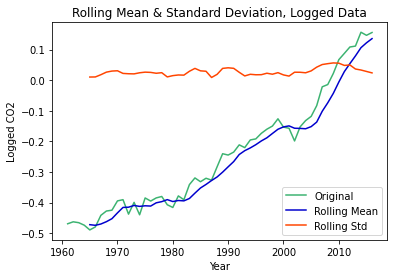

In [33]:
#apply log transformation
#Create new dataframe that contains the logged values of the original one
log_India = log(df_India)

#Visualize Logged data, including 5-year rolling mean and standard deviation
roll_mean_log = log_India.rolling(window=5, center=False).mean()
roll_std_log = log_India.rolling(window=5, center=False).std()

plt.plot(log_India, color='mediumseagreen', label='Original')
plt.plot(roll_mean_log, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std_log, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation, Logged Data')
plt.xlabel('Year')
plt.ylabel('Logged CO2')
plt.show(block=False)

Lets again check the p-value by doing a ADF test

**Dickey-Fuller test for log transformed data**

In [34]:
#perform Dickey-Fuller test for log tranformed data
test_result = adfuller(log_India.total[1:-1])
df_log_result = pd.Series(test_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_log_result

ADF Statistic                                                        1.713134
p-value                                                               0.99816
#Lags Used                                                                  1
No. of Observations Used                                                   52
Critical Values             {'1%': -3.562878534649522, '5%': -2.9189732840...
dtype: object

With p-value of 0.99 ( >0.05), we still cannot reject that null hypothesis that this data is non-stationary. 

Log transformation did not help achieve stationarity. So lets try another way to achieve true stationarity by subtracting rolling mean of log tranformation


#### Subtracting the Rolling Mean of the Log Transformation

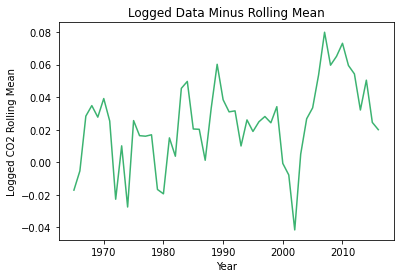

In [35]:
#subtracting rolling mean of log transformation
log_minus_rollmean = log_India - roll_mean_log

#drop null values
log_minus_rollmean.dropna(axis=0, inplace=True)

#observe data
plt.plot(log_minus_rollmean, color='mediumseagreen')
plt.title('Logged Data Minus Rolling Mean')
plt.xlabel('Year')
plt.ylabel('Logged CO2 Rolling Mean')
plt.show(block=False)

In [36]:
#perform Dickey-Fuller test for log-minus-rollmean data
test_result = adfuller(log_minus_rollmean['total'][1:-1])
df_sublog_result = pd.Series(test_result[0:5], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used', 'Critical Values'])
df_sublog_result

ADF Statistic                                                       -3.577277
p-value                                                              0.006211
#Lags Used                                                                  0
No. of Observations Used                                                   49
Critical Values             {'1%': -3.5714715250448363, '5%': -2.922629480...
dtype: object

With p-value of 0.006 ( >0.05), we can reject that null hypothesis that this data is stationary. 

Log transformation did help achieve stationarity

### Differencing

differencing is a very powerful technique to address non-stationary time-series data. Differencing works very well with practical time series.

The original data where the ADF test arrived at p-value = 1 suggests no difference between the groupds other than due to chance

Now that we have observed log tranformed, we will now observe differnece of our original data until we achieve stationarity so we can model on both datasets

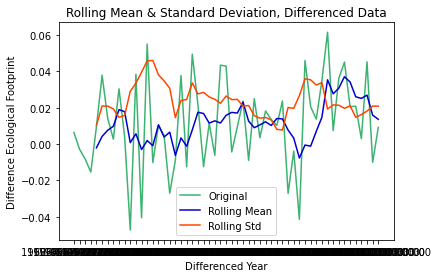

In [37]:
#create dataframe for differencing
log_diff = log_India.diff().dropna().rename(index=str, columns={"total":"Differenced Observations"})

#Visualize differenced data, inclusing 5-year rolling mean and standard deviation
roll_mean_diff = log_diff.rolling(window=5, center=False).mean()
roll_std_diff = log_diff.rolling(window=5, center=False).std()

plt.plot(log_diff, color='mediumseagreen', label='Original')
plt.plot(roll_mean_diff, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std_diff, color='orangered', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation, Differenced Data')
plt.xlabel('Differenced Year')
plt.ylabel('Difference Ecological Footprint')
plt.show(block=False)

In [38]:
#perform Dickey-Fuller test for log-minus-rollmean data
diff_result = adfuller(log_diff['Differenced Observations'][1:-1])
df_diff_result = pd.Series(diff_result[0:4], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used'])
df_diff_result

ADF Statistic              -8.563334e+00
p-value                     8.577288e-14
#Lags Used                  0.000000e+00
No. of Observations Used    5.200000e+01
dtype: float64

With p-value of 8.577288e-14 (<0.05), we reject that null hypothesis. This data does not have unit root and is stationary.

Based on real p-value of 8.577288e-14, we have achieved stationarity by 1st order differencing. We will keep this in count as we test d values in our ARIMA models

## Modelling

We will create time series models on our original data considering the order of differencing required to attain stationarity 

**ACF for Logged Data**

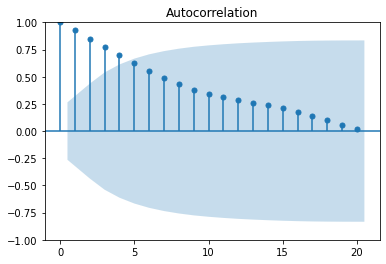

In [39]:
# observe ACF for logged data
plot_acf(df_India[:-1], alpha=.05, lags=20);

**PACF for Logged Data**

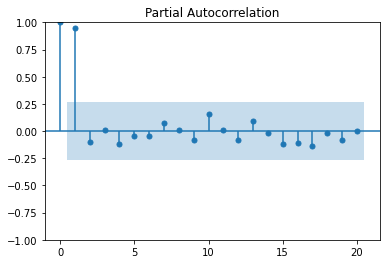

In [40]:
# PACF for original data
plot_pacf(df_India[:-1], alpha=.05, lags=20);

From the above ACF and PACF for our original data, we can observe

> - A series that has a dampened geometric decay of Autocorrelation and Significant at each lag  𝑝  / Cuts off after lag  𝑝 - AR  𝑝   model

> - Our data displayes an AR signature since ACF diminishes gradually and the PACF uctts off sharply at lag 2, showing string correlation. This tells us we would expect to have atleast one AR parameter.

> -  When instantiating an ARIMA model, we expect a relatively large number of MA terms due to large number of significant ACF points and relatively smaller AR terms due to small number of significant PACF points. 

**ARIMA Model for Original Data**

we tried many different p,d, and q parameters for an ARIMA model on our original data. The set of parameters yielded the best resutls, which we will comapre in mode details later.

In [41]:
#building the auto-arima model using GridSearch
from pmdarima.arima import auto_arima
model = auto_arima(df_India, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(df_India)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-259.714, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-224.830, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-252.299, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-262.697, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-262.575, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-262.070, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-260.919, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-263.692, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-222.831, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-263.859, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-250.299, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-257.807, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-

ARIMA(order=(1, 2, 1), scoring_args={}, suppress_warnings=True)

In [42]:
# Instantiate model
mod121 = ARIMA(df_India[:-1], order=(1,2,1))

# Fit model
mod121_fit = mod121.fit()

# Observe summary statistics
print(mod121_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:                   55
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 131.677
Date:                Mon, 25 Apr 2022   AIC                           -257.355
Time:                        01:49:27   BIC                           -251.444
Sample:                    01-01-1961   HQIC                          -255.082
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2613      0.161     -1.625      0.104      -0.576       0.054
ma.L1         -0.8295      0.099     -8.362      0.000      -1.024      -0.635
sigma2         0.0004   8.31e-05      4.749      0.0

## Determining the Best Model

To determina the best model of the above, we will fit them each to out train-test-split data and evaluate RMSE and AIC scores

We choose to split our train and test sets in 2011, which is 90%/10% split. We chose this split as there is a suddent exponential rise in the late 2000's. Inclusion of higher slope of rise will help the model predict in better wide reange

### Re-Fit Models to Train-Test Split Data 

In [214]:
# Train-test split
x = df_India.index
y = df_India['total']

train = df_India.loc[:'2011-01-01']
test = df_India.loc['2011-01-01':]

x_train, x_test = train.index, test.index
y_train, y_test = train['total'], test['total']

In [216]:
y_test

year
2011-01-01    1.091698
2012-01-01    1.114692
2013-01-01    1.117995
2014-01-01    1.169753
2015-01-01    1.158077
2016-01-01    1.168769
Name: total, dtype: float64

In [217]:
y_test

year
2011-01-01    1.091698
2012-01-01    1.114692
2013-01-01    1.117995
2014-01-01    1.169753
2015-01-01    1.158077
2016-01-01    1.168769
Name: total, dtype: float64

In [218]:
# 121 data
# Instantiate and fit model to train data
model121 = ARIMA(y_train[2:], order=(1,2,1)) #p,d,q
model121_fit = model121.fit()

#Prediction
pred121 = model121_fit.predict(start='1990-01-01', end='2016-01-01', dynamic=False)

### Analyze Final Model

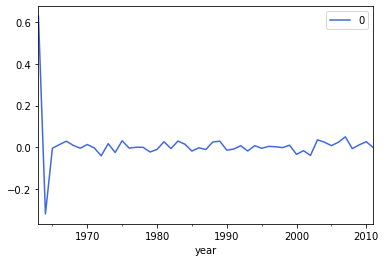

In [45]:
#Visualize resicudals
residuals = DataFrame(model121_fit.resid)
residuals.plot(color='royalblue')
plt.show()

In [46]:
#observe residuals/error distributions
residuals.describe()

,0
count,49.000000
mean,0.009600
std,0.103128
min,-0.319077
25%,-0.008359
50%,0.000330
75%,0.017525
max,0.627844


Based on the above, we observe that our model has minimal error with little bias, with a mean of approximately 0. Next, we observe a density plot of the residual error values, suggesting the errors ar gaussian, but may not be centered on zero

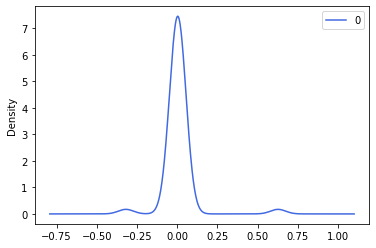

In [47]:
#check for linearlity
residuals = DataFrame(model121_fit.resid)
residuals.plot(kind='kde', color='royalblue')
plt.show()

Based on the above, we observe that our model is nearly linear, with mean of approximately 0. Next we observe the diagnostics to evaluate our model

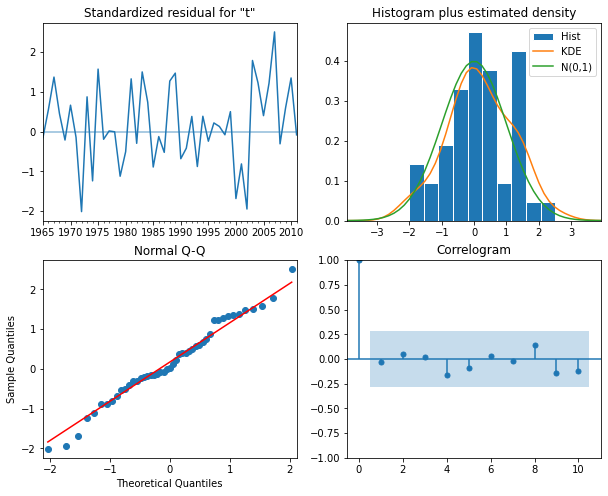

In [48]:
#observe diagonstics
model121_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In the top right plot, thw orangered line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation 1. This is a good indication thath the residuals are normally distributed. The forecast errors deviate a little bit from the straight line, indicating that the normal distribution is not a perfect model for the distribution of forecast errors, but it is not unreasonable.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again,this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e, correlation) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

In [49]:
#observe predictions
pred_model121 = model121_fit.get_prediction(start='1990-01-01', end='2016-01-01', dynamic=False)
pred_ci = pred_model121.conf_int()
pred_ci.head(10)

,lower total,upper total
1990-01-01,0.757512,0.835983
1991-01-01,0.759814,0.838284
1992-01-01,0.762769,0.841239
1993-01-01,0.780722,0.859192
1994-01-01,0.775766,0.854237
1995-01-01,0.791172,0.869642
1996-01-01,0.797159,0.875630
1997-01-01,0.810353,0.888823
1998-01-01,0.823286,0.901757
1999-01-01,0.832319,0.910789


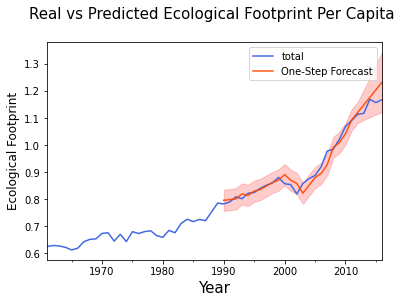

In [50]:
#observe real vs forecasted emissions values

#plot observed values
ax = df_India['1961-01-01':].plot(label='observed', color='royalblue')

#plot predicted values
pred_model121.predicted_mean.plot(ax=ax, label='One-Step Forecast', color='orangered', alpha=0.9)

#add fill between lines, set axes labels and title
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1],
               color='r', alpha=0.2)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('Ecological Footprint', size=12)
ax.set_title('Real vs Predicted Ecological Footprint Per Capita \n', size=15)

plt.legend()
plt.show()



The goal of developing the model is to get a good quality predictive power using dynamic forecast. That is, we use information from the timeseries up to a certain point, and after that point, forecasts are generated using values from historical time points 

In [51]:
#get dynamic predictions
pred_dynamic = model121_fit.get_prediction(start='1990-01-01', end='2016-01-01', dynamic=True, full_results=True)
#get confidence Intervals
pred_dynamic_ci = pred_dynamic.conf_int()
pred_dynamic_ci.sample(10)

,lower total,upper total
1991-01-01,0.757351,0.867746
2006-01-01,0.625626,1.440384
2008-01-01,0.595154,1.529700
1990-01-01,0.757512,0.835983
2007-01-01,0.610726,1.484706
2011-01-01,0.544536,1.668586
1996-01-01,0.733890,1.037892
2003-01-01,0.666133,1.311608
1998-01-01,0.718623,1.112006
2004-01-01,0.653345,1.353819


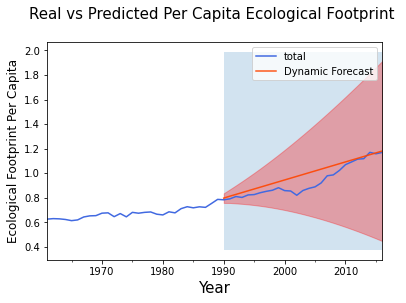

In [52]:
#plot observed values
ax = df_India['1960-01-01':].plot(label='observed', color='royalblue')

#plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orangered', alpha=0.9)

#add fill between lines, set axes labels and title
ax.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:, 0],
               pred_dynamic_ci.iloc[:, 1],
               color='r', alpha=0.3)

ax.fill_betweenx(ax.get_ylim(),
                '1990-01-01',
                df_India.index[-1],
                alpha=0.2,
                zorder= -1)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('Ecological Footprint Per Capita', size=12)
ax.set_title('Real vs Predicted Per Capita Ecological Footprint \n', size=15)

plt.legend()
plt.show()


**SARIMA Model**

In [53]:
#building the model
from pmdarima.arima import auto_arima
smodel = auto_arima(df_India, 
                   trace=True, 
                   error_action='ignore', 
                   suppress_warnings=True, 
                   seasonal=True, 
                   m=6, 
                   stepwise=True)
smodel_fit = smodel.fit(df_India)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[6]             : AIC=-254.894, Time=0.43 sec
 ARIMA(0,2,0)(0,0,0)[6]             : AIC=-224.830, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[6]             : AIC=-250.521, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[6]             : AIC=-260.854, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[6]             : AIC=-262.697, Time=0.05 sec
 ARIMA(0,2,1)(1,0,0)[6]             : AIC=-260.755, Time=0.10 sec
 ARIMA(0,2,1)(1,0,1)[6]             : AIC=-260.803, Time=0.14 sec
 ARIMA(1,2,1)(0,0,0)[6]             : AIC=-262.575, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[6]             : AIC=-262.070, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[6]             : AIC=-252.299, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[6]             : AIC=-260.919, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[6] intercept   : AIC=-263.692, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[6] intercept   : AIC=-261.839, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[6] intercept   : AIC=-262.318, Time=0.15 sec
 ARIMA(0,2,1)(1,0,1)[6] intercept

In [54]:
# Train-test split
xs = df_India.index
ys = df_India['total']

strain = df_India.loc[:'2011-01-01']
stest = df_India.loc['2011-01-01':]

x_strain, x_stest = strain.index, stest.index
y_strain, y_stest = strain['total'], stest['total']

DatetimeIndex(['1961-01-01', '1962-01-01', '1963-01-01', '1964-01-01',
               '1965-01-01', '1966-01-01', '1967-01-01', '1968-01-01',
               '1969-01-01', '1970-01-01', '1971-01-01', '1972-01-01',
               '1973-01-01', '1974-01-01', '1975-01-01', '1976-01-01',
               '1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01'],
     

In [236]:
#instatiate SARIMA Model
smodel = ARIMA(y_strain[2:],order=(1,2,1),seasonal_order=(0,0,0,6))
smodel_fit = smodel.fit()

#Prediction
pred_mods = smodel_fit.predict(start='1990-01-01', end='2016-01-01', dynamic=False)

In [237]:
pred_mods['2011-01-01':]

2011-01-01    1.093354
2012-01-01    1.121236
2013-01-01    1.148979
2014-01-01    1.177160
2015-01-01    1.205234
2016-01-01    1.233334
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [239]:
#observe predictions
pred_smodel = smodel_fit.get_prediction(start='1990-01-01', end='2020-01-01', dynamic=False)
pred_sci = pred_smodel.conf_int()
pred_sci.sample(10)

,lower total,upper total
2000-01-01,0.852428,0.930898
1997-01-01,0.810353,0.888823
1990-01-01,0.757512,0.835983
2013-01-01,1.093781,1.204177
1995-01-01,0.791172,0.869642
2011-01-01,1.054119,1.132589
2006-01-01,0.856707,0.935177
2002-01-01,0.819740,0.898210
2016-01-01,1.122512,1.344156
2020-01-01,1.149022,1.542405


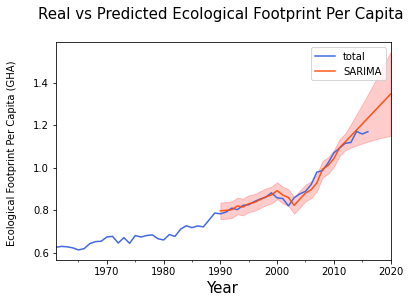

In [240]:
#observe real vs forecasted emissions values

#plot observed values
ax = df_India['1950-01-01':].plot(label='Observed EF', color='royalblue', legend=True)

#plot predicted values
pred_smodel.predicted_mean.plot(ax=ax, label='SARIMA', color='orangered', alpha=0.9, legend=True)

#add fill between lines, set axes labels and title
ax.fill_between(pred_sci.index,
               pred_sci.iloc[:, 0],
               pred_sci.iloc[:, 1],
               color='r', alpha=0.2)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('Ecological Footprint Per Capita (GHA) \n', size=10)
ax.set_title('Real vs Predicted Ecological Footprint Per Capita \n', size=15)

plt.show()

In [241]:
y_stest.shape

(6,)

### Evaluate Models

In [242]:
#evaluate mse
#Create a function to calculate RMSE for non-logged data
def RMSE(pred, test):
    return np.sqrt(((pred - y_test)**2).mean())

print("RMSE for the ARIMA Model : ", round(RMSE(pred121['2011-01-01':], y_test),5))
print("RMSE for the SARIMA Model : ", round(RMSE(pred_mods['2011-01-01':], y_stest),5))

RMSE for the ARIMA Model :  0.03524
RMSE for the SARIMA Model :  0.03524


In [244]:
from sklearn.metrics import mean_absolute_error
#Create a function to calculate AIC for our models
def MAE(test):
    return mean_absolute_error(estest['2011-01-01':].total, test)

print(" MAE for the ARIMA Model : ", round(MAE(pred121['2011-01-01':]),5))
print(" MAE for the SARIMA Model : ", round(MAE(pred_mods['2011-01-01':]),5))

 MAE for the ARIMA Model :  0.02639
 MAE for the SARIMA Model :  0.02639


In [246]:
#write a function to calculate MAPE value
def MAPE(test): 
    return np.mean(np.abs((estest.total['2011-01-01':] - test) / estest.total['2011-01-01':])) * 100

print(" MAPE for the ARIMA Model : ", round(MAPE(pred121['2011-01-01':]),3))
print(" MAPE for the SARIMA Model : ", round(MAPE(pred_mods['2011-01-01':]),3))

 MAPE for the ARIMA Model :  2.29
 MAPE for the SARIMA Model :  2.29


Based on the above, we see that our model on our original data is much more predcitive.
- We checked and we observed that SARIMA Model yields Similar results to ARIMA Model, because of less-seasonal character of the data


### Forecast Future Ecological Footprint Per Capita

In [59]:
#get forecast of 10 years stpes ahead in future
forecast2030 = model121_fit.get_forecast(steps=20)
#get confidence Intervals
forecast2030_ci = forecast2030.conf_int()
forecast2030_ci.tail(10)

,lower total,upper total
2022-01-01,1.157164,1.646644
2023-01-01,1.160029,1.699968
2024-01-01,1.162118,1.754069
2025-01-01,1.163452,1.808926
2026-01-01,1.164047,1.864521
2027-01-01,1.163923,1.920835
2028-01-01,1.163095,1.977853
2029-01-01,1.161579,2.035559
2030-01-01,1.159391,2.093937
2031-01-01,1.156544,2.152975


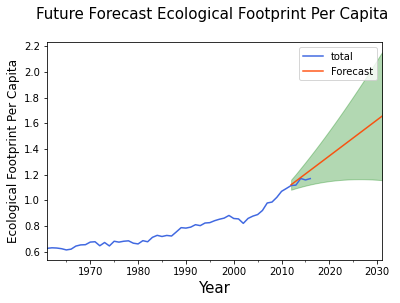

In [60]:
#plot observed values
ax = df_India['1961-01-01':].plot(label='observed', color='royalblue')

#plot Forecast values
forecast2030.predicted_mean.plot(ax=ax, label='Forecast', color='orangered', alpha=0.9)

#add fill between lines, set axes labels and title
ax.fill_between(forecast2030_ci.index,
               forecast2030_ci.iloc[:, 0],
               forecast2030_ci.iloc[:, 1],
               color='g', alpha=0.3)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('Ecological Footprint Per Capita', size=12)
ax.set_title('Future Forecast Ecological Footprint Per Capita \n', size=15)

plt.legend()
plt.show()

**Comparison**

Lets compare and observe the predicts of ARIMA and Holt-Winter's models

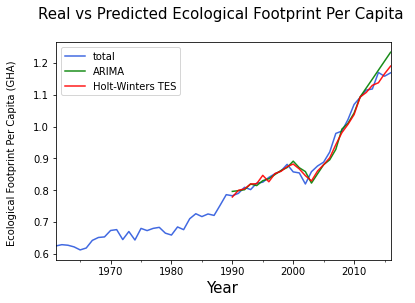

In [61]:
#plot observed values
ax = df_India['1951-01-01':].plot(label='observed', color='royalblue', legend=True)

#plot predicted values
#ARIMA Model
pred_model121.predicted_mean.plot(ax=ax, label='ARIMA', color='green', alpha=0.9, legend=True)
#Holt-Winter's TES
test_tes_pred = model_tes_fit.predict(start='1990-01-01', end='2016-01-01')
test_tes_pred.plot(ax=ax, label='Holt-Winters TES', color='red', alpha=0.9, legend = True)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('Ecological Footprint Per Capita (GHA) \n', size=10)
ax.set_title('Real vs Predicted Ecological Footprint Per Capita \n', size=15)

plt.legend()
plt.show()

Lets compare and observe the forecasts of ARIMA and Holt-Winter's models

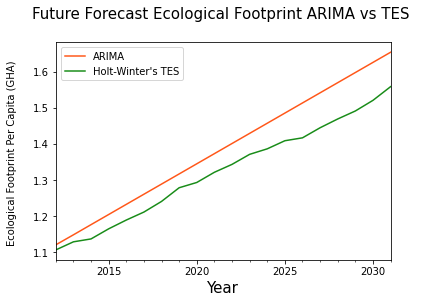

In [62]:
#plot Forecast values of ARIMA
ax = forecast2030.predicted_mean.plot( label='ARIMA', color='orangered', alpha=0.9, legend = True)

#plot Forecast values of Holt-Winter's
test_tes_20.plot(ax = ax, label = "Holt-Winter's TES", color='green', alpha=0.9,legend = True)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('Ecological Footprint Per Capita (GHA) \n', size=10)
ax.set_title('Future Forecast Ecological Footprint ARIMA vs TES \n', size=15)

plt.legend()
plt.show()

#### Comparison Evaluation

In [249]:
#evaluate RMSE for ARIMA and Holt-Winter's Model
print("RMSE for the ARIMA Model : ", round(RMSE(pred121, y_test),3))
print("RMSE for the Holt-Winter's Model : ", round(np.sqrt(tes_mse),3))


RMSE for the ARIMA Model :  0.035
RMSE for the Holt-Winter's Model :  0.025


In [252]:
#evaluate MAE for ARIMA and Holt-Winter's Model
print("MAE for the ARIMA Model : ", round(MAE(pred121['2011-01-01':]),3))
print("MAE for the Holt-Winter's Model : ", round(MAE(test_tes),3))

MAE for the ARIMA Model :  0.026
MAE for the Holt-Winter's Model :  0.022


In [253]:
#evaluate MAPE for ARIMA and Holt-Winter's Model
print(" MAPE for the ARIMA Model : ", round(MAPE(pred121['2011-01-01':]),3))
print(" MAPE for the Holt-Winter's Model : ", round(MAPE(test_tes),3))

 MAPE for the ARIMA Model :  2.29
 MAPE for the Holt-Winter's Model :  1.383


From above results, we can observe 

>- RMSE of Holt-Winter's (TES) is **lesser** than ARIMA
>- MAE of Holt-Winter's (TES) is **lesser** than ARIMA
>- MAPE of Holt-Winter's (TES) is **lesser** than ARIMA, means marginally better accuracy


***TES performs well for predicting data post 2011 compared to other Models***


### LSTM Model

**Reporducibility** is extremely important as the parameter makes sure that when code is re-run, produces similar results

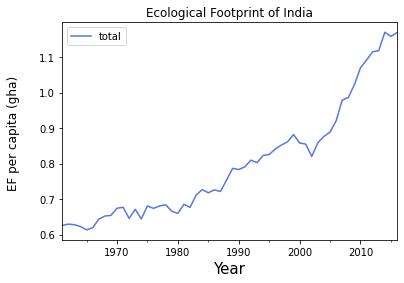

In [64]:
ax = df_India.plot(label='', color='royalblue', alpha=0.9, legend = True)
ax.set_xlabel('Year', size=15)
ax.set_ylabel('EF per capita (gha) \n', size=12)
ax.set_title('Ecological Footprint of India', size=12)

plt.legend()
plt.show()

In [65]:
#fix random seed for reproducibility
np.random.seed(42)

In [66]:
# Filter the target column from dataset and convert the dataframe to numpy
data = df_India['total']
dataset = df_India.values
dataset = dataset.astype('float32')

In [67]:
dataset.shape

(56, 1)

**Normalize Input**

As with other deep learning problems, we can help neural network learn more rapidly by normalizing the inputs between 0 and 1. We will use `MinMaxScaler` for normalizing the input

In [68]:
#normalize
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(dataset) #try standard scaler

In [69]:
scaled_dataset.shape

(56, 1)

**Split intro train and test sets**

In [291]:
#split train-set
train_size = int(len(scaled_dataset)*0.80)
test_size = len(scaled_dataset) - train_size
train, test = scaled_dataset[0:train_size,:], scaled_dataset[train_size:len(scaled_dataset),:]
print(len(train), len(test))

44 12


In [292]:
train.shape

(44, 1)

In [294]:
test.shape

array([[0.49482882],
       [0.5517682 ],
       [0.6567334 ],
       [0.66983724],
       [0.73519206],
       [0.8199109 ],
       [0.8597603 ],
       [0.90107274],
       [0.9070077 ],
       [1.        ],
       [0.9790211 ],
       [0.99823165]], dtype=float32)

In [295]:
# Convert the data into a Supervised-learning data

x = []
y = []
look_back = 4
for i in range(look_back, len(train)):
    x.append(train[i-look_back:i, 0])
    y.append(train[i, 0])

# Converting into numpy sequences to train the LSTM model
trainX, trainY = np.array(x), np.array(y) 

LSTM network should be fed with input data (X) with a specific array structure of form [Sample, time steps, features]

lets restructure the train and test input data to required format

In [296]:
# Reshape the training data to 3 dimensional for LSTM input.
X_train = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

In [297]:
X_train.shape

(40, 4, 1)

In [298]:
trainY.shape

(40,)

The network has a visible layer with 1 input, a hidden layer with 100 LSTM units and then gradually reducing it, and an output layer that makes a single value prediction. The relu activation function is used for the LSTM blocks.


In [299]:
#create and fit the LSTM network
modelx = Sequential()

#Add first LSTM layer with 20% dropout regularisation
modelx.add(LSTM(units = 100,
                return_sequences = True,
                activation = 'relu',
                input_shape = (X_train.shape[1], 1)))
modelx.add(Dropout(0.2))

#Add Second LSTM Layer
modelx.add(LSTM(units = 90,
                return_sequences = True,
                activation = 'relu'))
modelx.add(Dropout(0.2))
#Add Third LSTM Layer
modelx.add(LSTM(units = 90,
                activation = 'relu'))
modelx.add(Dropout(0.2))

#Add output layer
modelx.add(Dense(1))

In [300]:
#print model summary
modelx.summary()

#Visualize model architecture
#plot_model(modelx, show_shapes=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 4, 100)            40800     
                                                                 
 dropout_21 (Dropout)        (None, 4, 100)            0         
                                                                 
 lstm_22 (LSTM)              (None, 4, 90)             68760     
                                                                 
 dropout_22 (Dropout)        (None, 4, 90)             0         
                                                                 
 lstm_23 (LSTM)              (None, 90)                65160     
                                                                 
 dropout_23 (Dropout)        (None, 90)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [301]:
modelx.compile(loss='mean_squared_error', optimizer='adam')
history = modelx.fit(X_train,
                     trainY, 
                     epochs = 100, 
                     batch_size = 128, 
                     validation_split = 0.2, 
                     verbose = 1, 
                     shuffle = False)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.0437 - val_loss: 0.1885
Epoch 2/100
1/1 [==============================] - 0s 78ms/step - loss: 0.0415 - val_loss: 0.1829
Epoch 3/100
1/1 [==============================] - 0s 73ms/step - loss: 0.0394 - val_loss: 0.1768
Epoch 4/100
1/1 [==============================] - 0s 68ms/step - loss: 0.0372 - val_loss: 0.1700
Epoch 5/100
1/1 [==============================] - 0s 62ms/step - loss: 0.0346 - val_loss: 0.1626
Epoch 6/100
1/1 [==============================] - 0s 64ms/step - loss: 0.0323 - val_loss: 0.1547
Epoch 7/100
1/1 [==============================] - 0s 61ms/step - loss: 0.0300 - val_loss: 0.1464
Epoch 8/100
1/1 [==============================] - 0s 64ms/step - loss: 0.0270 - val_loss: 0.1376
Epoch 9/100
1/1 [==============================] - 0s 62ms/step - loss: 0.0243 - val_loss: 0.1283
Epoch 10/100
1/1 [==============================] - 0s 64ms/step - loss: 0.0223 - val_loss: 0.1186
Epoch 11/100
1/1 [===

Epoch 84/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 85/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 86/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 87/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 88/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 89/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 90/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 91/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 92/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 93/100
1/1 [==============================] - 0s 46ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 94/1

In [302]:
#Construct Metircs for the LSTM Model
metrics = pd.DataFrame(modelx.history.history)
metrics.head()

,loss,val_loss
0,0.043680,0.188549
1,0.041482,0.182867
2,0.039404,0.176792
3,0.037237,0.170048
4,0.034561,0.162599


Text(0, 0.5, 'Loss')

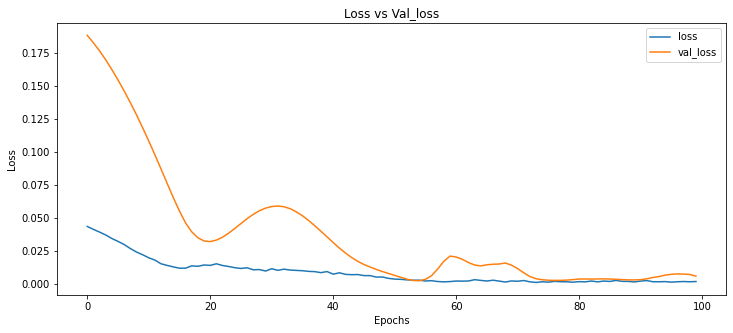

In [303]:
#Plot the loss of LSTM Model

metrics[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss vs Val_loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [304]:
# Prepare the test data for validation
test_data = scaled_dataset[train_size - look_back: , : ]

#Create the x_test and y_test data sets
X_test = []
y_test =  dataset[train_size : , : ]
for i in range(look_back, len(test_data)):
    X_test.append(test_data[i-look_back:i,0])

# Convert x_test to a numpy array
X_test = np.array(X_test)

In [323]:
# Prediction with the prepared LSTM model
predicted_EF = modelx.predict(X_test)

# Inverse scaling of predicted values to original scale
predicted_EF = scaler.inverse_transform(predicted_EF)

predicted_EF.shape


(12, 1)

#### Evaluate Model

In [310]:
# Determine the Root Mean Absoulute Error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test,predicted_EF))
print("Root Mean Square Error is:", round(rmse,3))

Root Mean Square Error is: 0.056


In [311]:
# Determine the Mean Absoulute Error
mae = mean_absolute_error(y_test,predicted_EF)
print("The Mean Absoulte Error is:", round(mae,3))

The Mean Absoulte Error is: 0.046


In [324]:
#Creare a function to calculate MAPE for our models
def MAPE(pred): 
    return np.mean(np.abs((y_test - pred) / y_test)) * 100

print('Mean Absolute Percentage Error is: ', round(MAPE(predicted_EF),3))


Mean Absolute Percentage Error is:  4.29


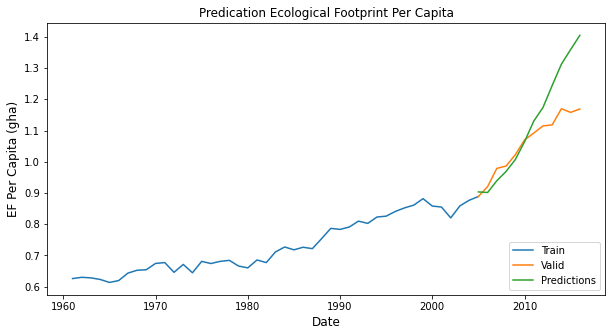

In [144]:
# Plot the train, predicted and validated data set

train = df_India[:train_size+1]
valid = df_India[train_size:]
valid['Predictions'] = predicted_EF
plt.figure(figsize=(10,5))
plt.title('Predication Ecological Footprint Per Capita')
plt.xlabel('Date', fontsize=12)
plt.ylabel('EF Per Capita (gha)', fontsize=12)
plt.plot(train['total'])
plt.plot(valid[['total', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [145]:
valid

,total,Predictions
year,,
2005-01-01,0.888584,0.903203
2006-01-01,0.920275,0.901422
2007-01-01,0.978697,0.939032
2008-01-01,0.985990,0.968771
2009-01-01,1.022366,1.006700
2010-01-01,1.069519,1.063920
2011-01-01,1.091698,1.129959
2012-01-01,1.114692,1.173442
2013-01-01,1.117995,1.244289


### Forecasting CO2 Emissions

Lets observe a forecast iver the entire data set with LSTM model

Since we converted the data into supervised data for a look_back of 4 years, we will  add initial 4 years to prevent data truncation

In [146]:
#process data to avoid truncation
test_data = df_India.head(4)
test_data = pd.concat([test_data, df_India])
test_data

,total
year,
1961-01-01,0.625609
1962-01-01,0.629613
1963-01-01,0.627844
1964-01-01,0.622689
1961-01-01,0.625609
1962-01-01,0.629613
1963-01-01,0.627844
1964-01-01,0.622689
1965-01-01,0.613171


In [147]:
#Normalize data 
target = test_data['total']
target_test = test_data.values
test_scaled = scaler.fit_transform(target_test)
test_scaled.shape

(60, 1)

In [148]:
test = test_scaled[:,:]

Convert the test data into supervised data for forecasting using built LSTM model

In [149]:
#convert data
xf_test = []
yf_test = dataset[: , :]

for i in range(look_back, len(test)):
    xf_test.append(test[i-look_back:i, 0])

#convert to a numpy array
xf_test = np.array(xf_test)

In [150]:
#reshape the data into dimensions of LSTM model
xf_test = xf_test.reshape(xf_test.shape[0], xf_test.shape[1], 1)
xf_test.shape

(56, 4, 1)

In [151]:
yf_test.shape

(56, 1)

In [152]:
#predictions of entire dataset using LSTM Model
predicted_EFx = modelx.predict(xf_test)
predicted_EFx = scaler.inverse_transform(predicted_EFx)
predicted_EFx

array([[0.6447742 ],
       [0.64526653],
       [0.64454794],
       [0.64405024],
       [0.6447742 ],
       [0.64523464],
       [0.6444343 ],
       [0.6436489 ],
       [0.6437223 ],
       [0.6490962 ],
       [0.662316  ],
       [0.67122346],
       [0.6776787 ],
       [0.6857496 ],
       [0.6792008 ],
       [0.66839427],
       [0.6790009 ],
       [0.6763518 ],
       [0.69582474],
       [0.69374084],
       [0.695203  ],
       [0.6910245 ],
       [0.68262947],
       [0.68900114],
       [0.7080948 ],
       [0.7179477 ],
       [0.7429994 ],
       [0.7503056 ],
       [0.7490116 ],
       [0.75995195],
       [0.77462286],
       [0.806083  ],
       [0.82841784],
       [0.8320792 ],
       [0.8438559 ],
       [0.85733056],
       [0.8621157 ],
       [0.8797989 ],
       [0.8905415 ],
       [0.908129  ],
       [0.9216102 ],
       [0.9302881 ],
       [0.9304285 ],
       [0.9094075 ],
       [0.90320325],
       [0.90142155],
       [0.93903214],
       [0.968

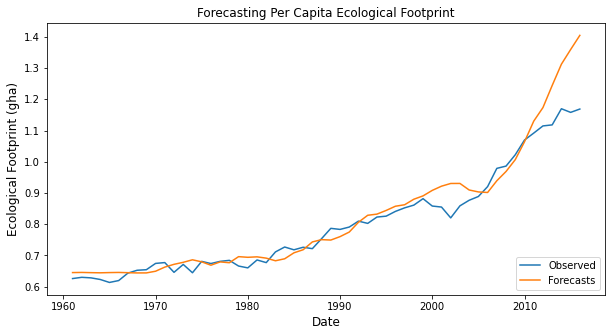

In [153]:
# Plot the original and predicted CO2 emissions set

pd.options.mode.chained_assignment = None 
train = df_India[:]
valid = df_India[:]
valid['Predictions'] = predicted_EFx
plt.figure(figsize=(10,5))
plt.title('Forecasting Per Capita Ecological Footprint')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Ecological Footprint (gha)', fontsize=12)
plt.plot(train['total'])
plt.plot(valid[['Predictions']])
plt.legend(['Observed', 'Forecasts'], loc='lower right')
plt.show()

#### Accuracy

In [320]:
# Evaluate mse
rmse = sqrt(mean_squared_error(yf_test,predicted_EFx))
print("Root Mean Square Error is:", round(rmse,3))

Root Mean Square Error is: 0.057


In [321]:
# Determine the Mean Absoulute Error
mae = mean_absolute_error(yf_test,predicted_EFx)
print("The Mean Absoulte Error is:", round(mae,3))

The Mean Absoulte Error is: 0.034


In [322]:
#Creare a function to calculate MAPE for our models
def MAPE(pred): 
    return np.mean(np.abs((yf_test - pred) / yf_test)) * 100

print('Mean Absolute Percentage Error is:', round(MAPE(predicted_EFx),3))

Mean Absolute Percentage Error is: 3.854


### Forecasting Future CO2 Emissions

Now lets observe future emissions using the LSTM model

In [155]:
valid.tail(4)

,total,Predictions
year,,
2013-01-01,1.117995,1.244289
2014-01-01,1.169753,1.312456
2015-01-01,1.158077,1.359371
2016-01-01,1.168769,1.404880


In [156]:
targetx = dataset

#nomalize data
targetx = scaler.fit_transform(targetx)

#reshape the dataset to be used for input in loop
targetx = targetx.reshape((-1))
targetx.shape

(56,)

In [157]:
#create a Loop for LSTM input

#here, the new data generated will be used as input fir next year forecast

#look_back is the input year for forecasting

look_back = 4
def predict(n, model):
    pred_list = targetx[-look_back:]
    
    for i in range(n):
        x = pred_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        pred_list = np.append(pred_list, out)
    pred_list = pred_list[look_back-1:]
    
    return pred_list

# for n years of future co2 emissions forecasting

n = 5
forecast5 = predict(n, modelx)

In [158]:
forecast5

array([0.99823165, 1.4917257 , 1.6789272 , 1.9561749 , 2.7090676 ,
       4.6907916 ], dtype=float32)

In [159]:
#reshape the forecast for inverse scaling to original values
forecast5 = forecast5.reshape(forecast5.shape[0], 1)
forecast5.shape

(6, 1)

In [160]:
#inverse scaling to obtain original values
forecast5 = scaler.inverse_transform(forecast5)

In [161]:
#forecast co2 emissions for next n years
forecast5

array([[1.168769 ],
       [1.4434392],
       [1.5476323],
       [1.7019436],
       [2.1209905],
       [3.223984 ]], dtype=float32)

In [162]:
#Add to the previous predicted dataset
forecast5 = np.append(predicted_EFx, forecast5)
forecasts = pd.DataFrame(forecast5, columns = ['forecasts'])

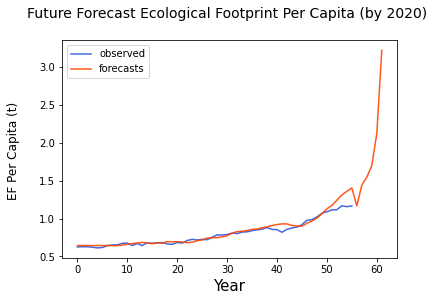

In [163]:
# Plot the original and LSTM forecasting CO2 emissions
data = df_India['1961-01-01':]
train = df_India.values
train = train.astype('float')
train = pd.DataFrame(train, columns = ['total'])
ax = train['total'].plot(label='observed', color='royalblue', legend=True)

#plot forecasted values
forecasts.plot(ax=ax, label='forecasts', color='orangered', alpha=0.9, legend=True)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('EF Per Capita (t) \n', size=12)
ax.set_title('Future Forecast Ecological Footprint Per Capita (by 2020) \n', size=14)

plt.legend()
plt.show()

***Results Observed***

From the above comparison fo ARIMA, Holt-Winter's and LSTM Model, 

>- LSTM Model gives least desirable results with higher RMSE value, We don't further continue as ARIMA and Holt-winter's provides desirable results

>- Comparing the MAPE Scores 
    - LSTM Model : 3.85
    - ARIMA Model : 2.29
    - Holt-Winter's Model : 1.38 
    
Thus the Results observed from ***Holt-Winter's Model*** can be inferred further as it is **more accurate*** than LSTM and ARIMA Models
   
   
    

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**tasks**


> - Modeling (ongoing)
    - _ARIMA_
    - _SARIMA_ (yields similar results to ARIMA)
    - _Holt's DES_
    - _Holt-winter's TES_
> - _Determine best model via RMSE_
> - _Forecast for target years_

> - Model Neural Networks
    - _LSTM_
> - _Determine best model via RMSE, MAE, MAPE_
> - _Forecast for target years_